In [16]:
df = pd.read_csv("../data/telecom_churn.csv")

df["International plan"] = pd.factorize(df["International plan"])[0]
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]
df["Churn"] = df["Churn"].astype("int")
states = df["State"]
y = df["Churn"]
df.drop(["State", "Churn"], axis=1, inplace=True)

In [17]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(
    df.values, y, test_size=0.3, random_state=17
)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [19]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)  # 0.94

0.94

In [20]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout, knn_pred)  # 0.89

0.89

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {"max_depth": range(1, 11), "max_features": range(4, 19)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [22]:
tree_grid.best_params_  # {'max_depth': 6, 'max_features': 17}

{'max_depth': 6, 'max_features': 17}

In [23]:
tree_grid.best_score_  # 0.94256322331761677

0.9425632233176168

In [24]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))  # 0.946

0.946

In [25]:
tree_graph_to_png(
    tree=tree_grid.best_estimator_,
    feature_names=df.columns,
    png_file_to_save="topic3_decision_tree4.png",
)

<img src="https://habrastorage.org/webt/0i/xs/yb/0ixsyb-galpvl9wkvyhasu8f0i8.png" />

Now, let's tune the number of neighbors $k$ for k-NN:

In [26]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.5s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'knn__n_neighbors': 7}, 0.8859837119588513)

In [27]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))  # 0.89

0.89

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))  # 0.949

0.9494233119813256


In [29]:
forest_params = {"max_depth": range(6, 12), "max_features": range(4, 19)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_  # ({'max_depth': 9, 'max_features': 6}, 0.951)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.4min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 9, 'max_features': 6}, 0.9511358765537934)

In [30]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))  # 0.953

0.953

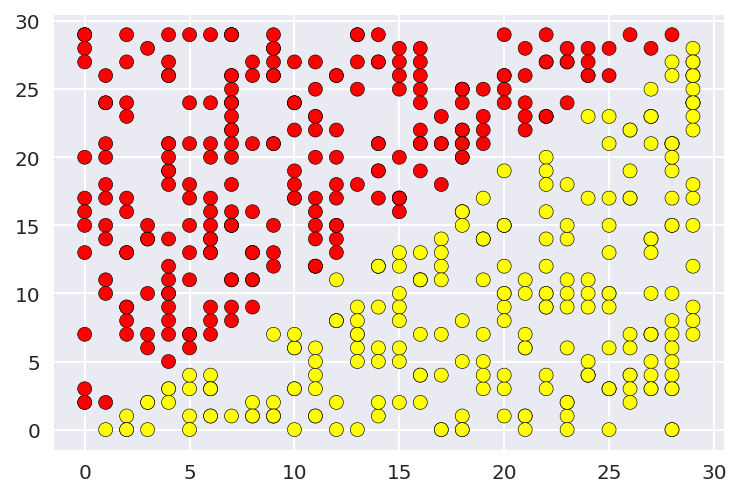

In [31]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="autumn", edgecolors="black");

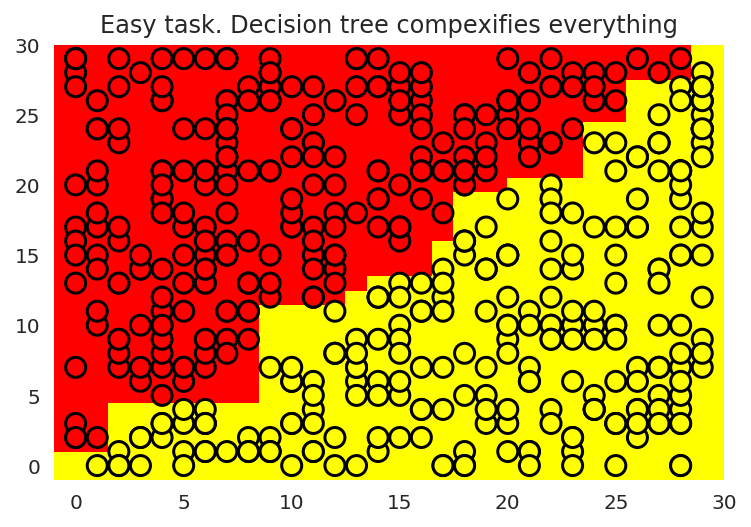

In [32]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task. Decision tree compexifies everything");

In [33]:
tree_graph_to_png(
    tree=tree,
    feature_names=["x1", "x2"],
    png_file_to_save="topic3_decision_tree5.png",
)

<img src="https://habrastorage.org/webt/az/ld/yj/azldyj0ija_sxkk438m959qpf0w.png" />

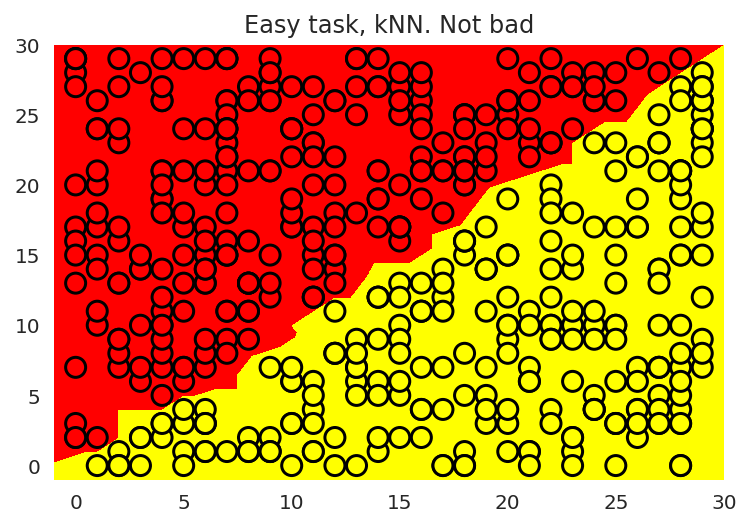

In [34]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task, kNN. Not bad");

In [35]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

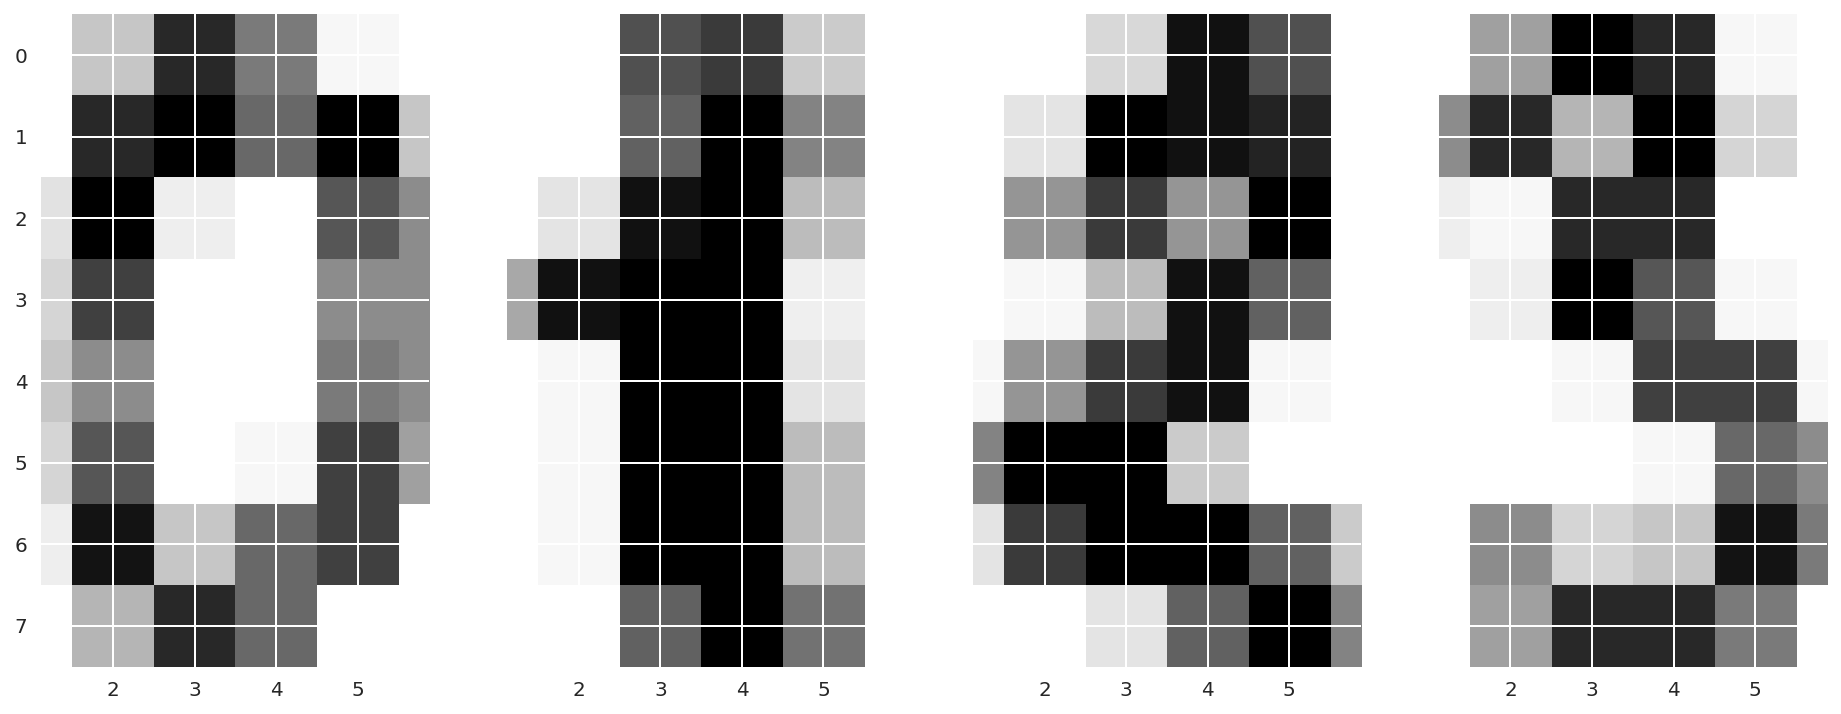

In [36]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

In [37]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [38]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);

In [39]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(
    y_holdout, tree_pred
)  # (0.976, 0.666)

(0.975925925925926, 0.6666666666666666)

In [40]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features": [1, 2, 3, 5, 10, 20, 30, 50, 64],
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    1.1s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64], 'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [41]:
tree_grid.best_params_, tree_grid.best_score_  # ({'max_depth': 20, 'max_features': 64}, 0.844)

({'max_depth': 20, 'max_features': 64}, 0.8440731901352426)

In [42]:
np.mean(
    cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)
)  # 0.987

0.9865458422397149

In [43]:
np.mean(
    cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5)
)  # 0.935

0.9349085619110404

In [44]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)

    # first feature is proportional to target
    x1 = 0.3 * y

    # other features are noise

    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y


X, y = form_noisy_data()

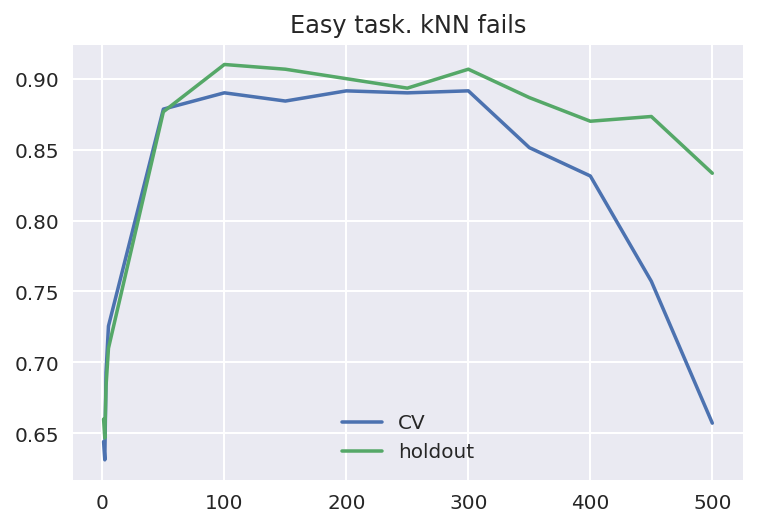

In [45]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn_pipe = Pipeline(
        [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]
    )
    cv_scores.append(np.mean(cross_val_score(knn_pipe, X_train, y_train, cv=5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn_pipe.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label="CV")
plt.plot(n_neighb, holdout_scores, label="holdout")
plt.title("Easy task. kNN fails")
plt.legend();

In [46]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print("Decision tree. CV: {}, holdout: {}".format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0
